In [1]:
import os
import pickle
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from schedulefree import RAdamScheduleFree
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

In [2]:
def seed_everything(seed):
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.use_deterministic_algorithms(True)

seed_everything(0)

In [3]:
INPUT_DIR = "code/src/models/scripts/data"
MODEL_DIR = "./"
OUTPUT_DIR = "./"

In [4]:
@dataclass
class Config:
    seq_len: int = 75
    n_splits: int = 5
    n_seeds: int = 1
    n_epochs: int = 20
    batch_size: int = 32
    lr: float = 2e-4
    betas: tuple[float, float] = (0.9, 0.999)
    label_smoothing: float = 0.01
    aux_loss_weight: float = 0.3


config = Config()


In [5]:
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
from scipy.spatial.transform import Rotation as R


class Preprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.scaler.set_output(transform="pandas")

    def _add_linear_acc(self, df: pl.DataFrame) -> pl.DataFrame:
        acc_values = df.select(["acc_x", "acc_y", "acc_z"]).to_numpy()
        quat_values = df.select(["rot_x", "rot_y", "rot_z", "rot_w"]).to_numpy()
        linear_acc_values = np.full_like(acc_values, np.nan)
        gravity_world = np.array([0, 0, 9.81])

        for i in range(len(df)):
            if np.all(np.isnan(quat_values[i])):
                continue
            rotation = R.from_quat(quat_values[i])
            gravity_values = rotation.apply(gravity_world, inverse=True)
            linear_acc_values[i, :] = acc_values[i, :] - gravity_values

        df_add = (
            pl.DataFrame(
                linear_acc_values,
                schema=["linear_acc_x", "linear_acc_y", "linear_acc_z"],
            )
            .fill_nan(None)
        )
        df = pl.concat([df, df_add], how="horizontal")
        return df

    def _add_rotvec_diff(self, df: pl.DataFrame) -> pl.DataFrame:
        ids = df.select("sequence_id").to_series().to_numpy()
        quat_values = df.select(["rot_x", "rot_y", "rot_z", "rot_w"]).to_numpy()
        rotvec_diff_values = np.full((len(df), 3), np.nan)

        for i in range(1, len(df)):
            if ids[i - 1] != ids[i]:
                continue
            q1 = quat_values[i - 1]
            q2 = quat_values[i]
            if np.all(np.isnan(q1)) or np.all(np.isnan(q2)):
                continue
            rot1 = R.from_quat(q1)
            rot2 = R.from_quat(q2)
            rotvec_diff_values[i, :] = (rot1.inv() * rot2).as_rotvec()

        df_add = (
            pl.DataFrame(
                rotvec_diff_values,
                schema=["rotvec_diff_x", "rotvec_diff_y", "rotvec_diff_z"],
            )
            .fill_nan(None)
        )
        df = pl.concat([df, df_add], how="horizontal")
        return df

    def _cancel_z_rotation(self, df: pl.DataFrame) -> pl.DataFrame:
        quat_values = df.select(["rot_x", "rot_y", "rot_z", "rot_w"]).to_numpy()
        rotate_flags = df.select("rotate").to_series().to_numpy()

        for i in range(len(df)):
            if np.all(np.isnan(quat_values[i])):
                continue
            rotation = (
                R.from_rotvec(
                    [0, 0, 130 + 180 * rotate_flags[i]],
                    degrees=True,
                )
                * R.from_quat(quat_values[i])
            )
            quat_values[i, :] = rotation.as_quat(
                canonical=True,
                scalar_first=True,
            )

        df_add = (
            pl.DataFrame(
                quat_values,
                schema=["rot_w", "rot_x", "rot_y", "rot_z"],
            )
            .fill_nan(None)
        )

        df = pl.concat(
            [df.drop(["rot_w", "rot_x", "rot_y", "rot_z"]), df_add],
            how="horizontal",
        )
        return df

    def _add_global_acc(self, df: pl.DataFrame) -> pl.DataFrame:
        acc_values = df.select(["acc_x", "acc_y", "acc_z"]).to_numpy()
        quat_values = df.select(["rot_x", "rot_y", "rot_z", "rot_w"]).to_numpy()
        global_acc_values = np.full_like(acc_values, np.nan)

        for i in range(len(df)):
            if np.all(np.isnan(quat_values[i])):
                continue
            rotation = R.from_quat(quat_values[i])
            global_acc_values[i, :] = rotation.apply(acc_values[i, :])

        df_add = (
            pl.DataFrame(
                global_acc_values,
                schema=["global_acc_x", "global_acc_y", "global_acc_z"],
            )
            .fill_nan(None)
        )

        df = pl.concat([df, df_add], how="horizontal")
        return df

    def _handle_left_handed(self, df: pl.DataFrame) -> pl.DataFrame:
        df = (
            df.with_columns(
                *[
                    pl.when(pl.col("handedness") == 0)
                    .then(-pl.col(col))
                    .otherwise(pl.col(col))
                    .alias(col)
                    for col in [
                        "acc_x",
                        "linear_acc_x",
                        "global_acc_x",
                        "rot_y",
                        "rot_z",
                        "rotvec_diff_y",
                        "rotvec_diff_z",
                    ]
                ],
            )
            .with_columns(
                pl.when(pl.col("handedness") == 0)
                .then(pl.col("thm_5"))
                .otherwise(pl.col("thm_3"))
                .alias("thm_3"),
                pl.when(pl.col("handedness") == 0)
                .then(pl.col("thm_3"))
                .otherwise(pl.col("thm_5"))
                .alias("thm_5"),
                *[
                    pl.when(pl.col("handedness") == 0)
                    .then(pl.col(f"tof_5_v{i}"))
                    .otherwise(pl.col(f"tof_3_v{i}"))
                    .alias(f"tof_3_v{i}")
                    for i in range(64)
                ],
                *[
                    pl.when(pl.col("handedness") == 0)
                    .then(pl.col(f"tof_3_v{i}"))
                    .otherwise(pl.col(f"tof_5_v{i}"))
                    .alias(f"tof_5_v{i}")
                    for i in range(64)
                ],
            )
            .with_columns(
                *[
                    pl.when(pl.col("handedness") == 0)
                    .then(pl.col(f"tof_{i}_v{8 * j + 7 - k}"))
                    .otherwise(pl.col(f"tof_{i}_v{8 * j + k}"))
                    .alias(f"tof_{i}_v{8 * j + k}")
                    for i in range(1, 6)
                    for j in range(8)
                    for k in range(8)
                ],
            )
        )

        return df

    def _handle_rotated_device(self, df: pl.DataFrame) -> pl.DataFrame:
        df = (
            df.with_columns(
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(-pl.col(col))
                    .otherwise(pl.col(col))
                    .alias(col)
                    for col in [
                        "acc_x",
                        "acc_y",
                        "linear_acc_x",
                        "linear_acc_y",
                        "global_acc_x",
                        "global_acc_y",
                        "rot_x",
                        "rot_y",
                        "rotvec_diff_x",
                        "rotvec_diff_y",
                    ]
                ],
            )
            .with_columns(
                pl.when(pl.col("rotate") == 1)
                .then(pl.col("thm_4"))
                .otherwise(pl.col("thm_2"))
                .alias("thm_2"),
                pl.when(pl.col("rotate") == 1)
                .then(pl.col("thm_2"))
                .otherwise(pl.col("thm_4"))
                .alias("thm_4"),
                pl.when(pl.col("rotate") == 1)
                .then(pl.col("thm_5"))
                .otherwise(pl.col("thm_3"))
                .alias("thm_3"),
                pl.when(pl.col("rotate") == 1)
                .then(pl.col("thm_3"))
                .otherwise(pl.col("thm_5"))
                .alias("thm_5"),
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(pl.col(f"tof_4_v{i}"))
                    .otherwise(pl.col(f"tof_2_v{i}"))
                    .alias(f"tof_2_v{i}")
                    for i in range(64)
                ],
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(pl.col(f"tof_2_v{i}"))
                    .otherwise(pl.col(f"tof_4_v{i}"))
                    .alias(f"tof_4_v{i}")
                    for i in range(64)
                ],
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(pl.col(f"tof_5_v{i}"))
                    .otherwise(pl.col(f"tof_3_v{i}"))
                    .alias(f"tof_3_v{i}")
                    for i in range(64)
                ],
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(pl.col(f"tof_3_v{i}"))
                    .otherwise(pl.col(f"tof_5_v{i}"))
                    .alias(f"tof_5_v{i}")
                    for i in range(64)
                ],
            )
            .with_columns(
                *[
                    pl.when(pl.col("rotate") == 1)
                    .then(pl.col(f"tof_{i}_v{63 - j}"))
                    .otherwise(pl.col(f"tof_{i}_v{j}"))
                    .alias(f"tof_{i}_v{j}")
                    for i in range(1, 6)
                    for j in range(64)
                ],
            )
        )

        return df

    def preprocess(self, df: pl.DataFrame) -> pl.DataFrame:
        if "rotate" not in df.columns:
            df = df.with_columns(pl.lit(0).alias("rotate"))

        df = self._add_linear_acc(df)
        df = self._add_rotvec_diff(df)
        df = self._cancel_z_rotation(df)
        df = self._add_global_acc(df)
        df = self._handle_left_handed(df)
        df = self._handle_rotated_device(df)

        
        df = df.with_columns(
            pl.col("^tof_._v.*$").replace({-1: 255}),
        )

        return df

    def _get_reversed_sequence_tail(
        self,
        df: pl.DataFrame,
        seq_len: int,
    ) -> pl.DataFrame:
        df_tail = (
            df.sort(
                ["sequence_id", "sequence_counter"],
                descending=[False, True],
            )
            .group_by("sequence_id", maintain_order=True)
            .head(seq_len)
            .with_columns(
                pl.col("sequence_counter")
                .cum_count()
                .over("sequence_id"),
            )
        )

        return df_tail

    def get_feature_array(
        self,
        df: pl.DataFrame,
        list_features: list,
        seq_len: int,
        fit: bool = False,
    ) -> np.ndarray:
        df_tail = self._get_reversed_sequence_tail(df, seq_len)

        if fit:
            self.scaler.fit(df_tail.select(list_features))

        df_tail = df_tail.to_pandas()
        df_tail[list_features] = self.scaler.transform(
            df_tail[list_features]
        )
        df_tail = pl.from_pandas(df_tail).fill_null(0.0)

        feature_arrays = []
        for _, df_group in df_tail.group_by(
            "sequence_id",
            maintain_order=True,
        ):
            array = df_group.select(list_features).to_numpy().T
            array = np.pad(
                array,
                ((0, 0), (0, seq_len - array.shape[-1])),
            )
            feature_arrays.append(array)

        return np.stack(feature_arrays, axis=0)


In [6]:
target_gestures = [
    "Above ear - pull hair",
    "Cheek - pinch skin",
    "Eyebrow - pull hair",
    "Eyelash - pull hair",
    "Forehead - pull hairline",
    "Forehead - scratch",
    "Neck - pinch skin",
    "Neck - scratch",
]
non_target_gestures = [
    "Write name on leg",
    "Wave hello",
    "Glasses on/off",
    "Text on phone",
    "Write name in air",
    "Feel around in tray and pull out an object",
    "Scratch knee/leg skin",
    "Pull air toward your face",
    "Drink from bottle/cup",
    "Pinch knee/leg skin",
]
all_gestures = target_gestures + non_target_gestures
dict_gestures = {v: i for i, v in enumerate(all_gestures)}

In [7]:
df = pl.read_csv(f"train.csv")
df_demo = pl.read_csv(f"train_demographics.csv")
df = df.join(df_demo, on="subject", how="left")

In [8]:
subjects_rotated = ["SUBJ_019262", "SUBJ_045235"]
df = df.with_columns(pl.col("subject").is_in(subjects_rotated).cast(pl.Int16).alias("rotate"))

In [9]:
pp = Preprocessor()
df = pp.preprocess(df)

In [10]:
n_imu_blocks = 4

# ✅ IMU feature blocks ONLY (THM is passed separately as X_thm)
imu_feature_blocks = [
    ["acc_x", "acc_y", "acc_z"],
    ["rot_w", "rot_x", "rot_y", "rot_z"],
    ["linear_acc_x", "linear_acc_y", "linear_acc_z", "global_acc_x", "global_acc_y", "global_acc_z"],
    ["rotvec_diff_x", "rotvec_diff_y", "rotvec_diff_z"],
]

thm_names = [f"thm_{i}" for i in range(1, 6)]  # thm_1..thm_5

# Features used to build the raw feature array (we will later split out THM and ToF)
list_features = (
    sum(imu_feature_blocks, [])
    + thm_names
    + [f"tof_{i}_v{j}" for i in range(1, 6) for j in range(64)]
)


In [11]:
# ============================================================
# 1) BUILD RAW FEATURE ARRAY
# ============================================================
X_all = pp.get_feature_array(df, list_features, seq_len=config.seq_len, fit=True)  # (N, C_total, T)

# ------------------------------------------------------------
# Valid (non-padding) mask per timestep: (N, 1, T)
# ------------------------------------------------------------
mask_valid = (X_all != 0).max(axis=1, keepdims=True).astype(np.float32)

# ============================================================
# 2) GESTURE SEGMENT (TARGET for U-Net, NOT an input feature)
#    1 = gesture phase, 0 = non-gesture phase
# ============================================================
gesture_segment_true = (
    df.sort(["sequence_id", "sequence_counter"], descending=[False, True])
    .group_by("sequence_id", maintain_order=True)
    .head(config.seq_len)
    .with_columns(pl.col("sequence_counter").cum_count().over("sequence_id"))
    .with_columns((pl.col("phase") == "Gesture").cast(pl.Int8).alias("gesture_segment"))
    .pivot(on="sequence_counter", index="sequence_id", values="gesture_segment")
    .fill_null(0)
    .drop("sequence_id")
    .to_numpy()
)

gesture_segment_true = gesture_segment_true[:, np.newaxis, : config.seq_len].astype(np.float32)
# mask out padding
gesture_segment_true = gesture_segment_true * mask_valid

# ============================================================
# 3) SPLIT OUT THM FROM X_all  -> X_thm (N, T, 5)
# ============================================================
thm_indices = [list_features.index(name) for name in thm_names]
X_thm_raw = X_all[:, thm_indices, :]                    # (N, 5, T)
X_thm = np.transpose(X_thm_raw, (0, 2, 1)).astype(np.float32)  # (N, T, 5)

# Remove THM channels from X_all so X carries ONLY IMU + ToF
X_no_thm = np.delete(X_all, thm_indices, axis=1)        # (N, C_imu+tof, T)

# ============================================================
# 4) SPLIT OUT TOF (last 320 channels) -> X_tof (N, T, 320)
# ============================================================
X, X_tof = X_no_thm[:, :-320], X_no_thm[:, -320:]       # X: (N, C_imu, T), X_tof: (N, 320, T)
X_tof = np.transpose(X_tof, (0, 2, 1)).astype(np.float32)  # (N, T, 320)

# Ensure float32
X = X.astype(np.float32)

print("X (IMU) shape:", X.shape)                        # (N, 16, T)
print("X_tof shape:", X_tof.shape)                      # (N, T, 320)
print("X_thm shape:", X_thm.shape)                      # (N, T, 5)
print("gesture_segment_true shape:", gesture_segment_true.shape)  # (N, 1, T)
print("mask_valid shape:", mask_valid.shape)            # (N, 1, T)

with open(f"{MODEL_DIR}/preprocessor.pickle", "wb") as f:
    pickle.dump(pp, f)


X_thm shape: (8151, 75, 5)
X shape: (8151, 22, 75) X_tof shape: (8151, 75, 5, 8, 8) X_thm shape: (8151, 75, 5)


In [12]:
orientations = sorted(df["orientation"].unique())
dict_orientations = {v: i for i, v in enumerate(orientations)}

In [13]:
Y_main = (
    df.select(["sequence_id", "gesture"])
    .unique(maintain_order=True)
    .select(pl.col("gesture").replace(dict_gestures).cast(pl.Int8))
    .to_series()
    .to_numpy()
)
Y_aux = (
    df.select(["sequence_id", "orientation"])
    .unique(maintain_order=True)
    .select(pl.col("orientation").replace(dict_orientations).cast(pl.Int8))
    .to_series()
    .to_numpy()
)
Y = np.stack([Y_main, Y_aux], axis=1)
groups = df.select(["sequence_id", "subject"]).unique(maintain_order=True).select("subject").to_series().to_numpy()

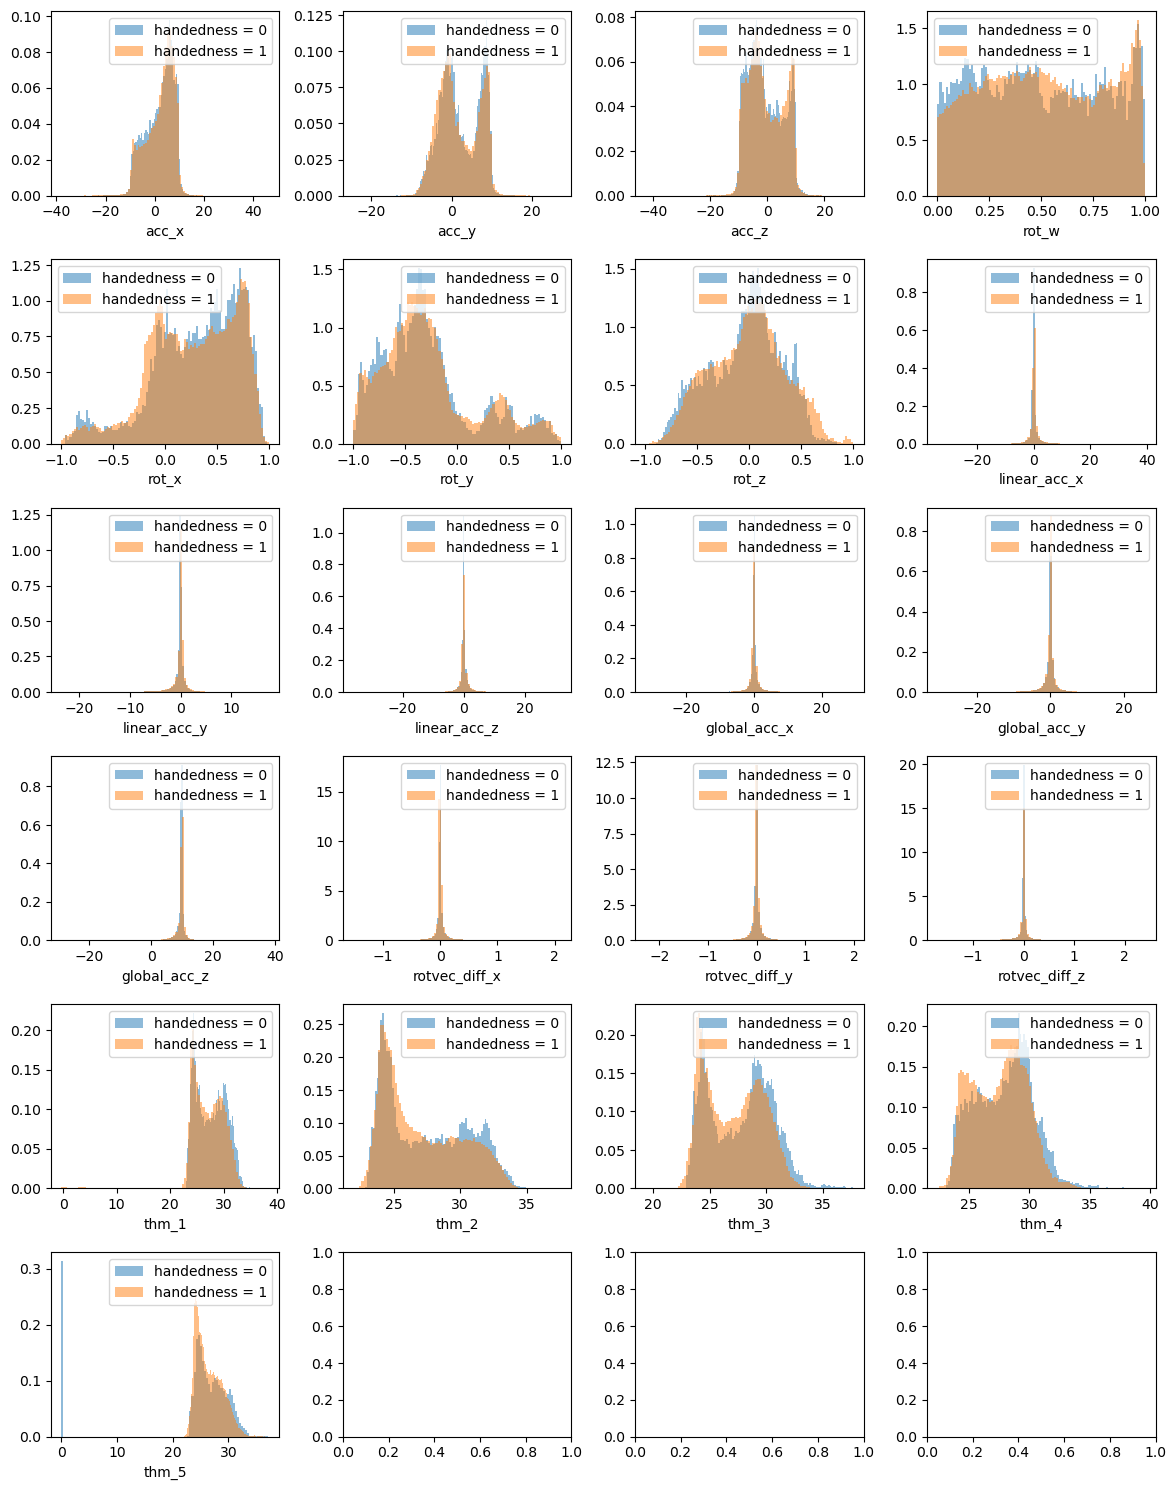

In [16]:
cols_fig = sum(imu_feature_blocks, []) + thm_names
nrows = (len(cols_fig) + 3) // 4
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, nrows * 2.5))
axes = axes.flatten()

for i, col in enumerate(cols_fig):
    for j in range(2):
        axes[i].hist(
            df.filter(pl.col("handedness") == j).select(col),
            bins=100,
            density=True,
            alpha=0.5,
            label=f"handedness = {j}",
        )
    axes[i].set_xlabel(col)
    axes[i].legend()

fig.tight_layout()
plt.show()


In [14]:
class MyDataset(Dataset):
    def __init__(self, X, X_tof, X_thm, y_gesture=None, y_orientation=None, gesture_segment_true=None, mask_valid=None):
        self.X     = torch.tensor(X, dtype=torch.float32)         # (N, C, T)
        self.X_tof = torch.tensor(X_tof, dtype=torch.float32)     # (N, T, 320)
        self.X_thm = torch.tensor(X_thm, dtype=torch.float32)     # (N, T, 5)

        self.has_labels = (y_gesture is not None) and (y_orientation is not None)

        if self.has_labels:
            self.y_gesture = torch.tensor(y_gesture, dtype=torch.long)       # (N,)
            self.y_orient  = torch.tensor(y_orientation, dtype=torch.long)   # (N,)

        # Optional: U-Net supervision
        self.has_segment = gesture_segment_true is not None
        if self.has_segment:
            self.gesture_segment_true = torch.tensor(gesture_segment_true, dtype=torch.float32)  # (N, 1, T)

        self.has_mask = mask_valid is not None
        if self.has_mask:
            self.mask_valid = torch.tensor(mask_valid, dtype=torch.float32)  # (N, 1, T)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if not self.has_labels:
            return self.X[idx], self.X_tof[idx], self.X_thm[idx]

        if self.has_segment and self.has_mask:
            return (self.X[idx], self.X_tof[idx], self.X_thm[idx],
                    self.y_gesture[idx], self.y_orient[idx],
                    self.gesture_segment_true[idx], self.mask_valid[idx])

        return self.X[idx], self.X_tof[idx], self.X_thm[idx], self.y_gesture[idx], self.y_orient[idx]


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F



"""
Conv2D with ReLU for the ToF
"""
class Conv2DReLUBN(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                padding="same"
            ),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


class ToF_2D_Block(nn.Module):
    def __init__(self, output_channels, kernel_size):
        super().__init__()
        self.layers = nn.Sequential(
            Conv2DReLUBN(
                in_channels=1,
                output_channels=output_channels,
                kernel_size=kernel_size
            ),
            nn.MaxPool2d(kernel_size=2),

            Conv2DReLUBN(
                in_channels=output_channels,
                output_channels=output_channels,
                kernel_size=kernel_size
            ),
            nn.MaxPool2d(kernel_size=2),

            Conv2DReLUBN(
                in_channels=output_channels,
                output_channels=output_channels,
                kernel_size=kernel_size
            ),
            nn.MaxPool2d(kernel_size=2),
        )

    def forward(self, x):
        return self.layers(x)


"""
Simple Conv1D block without LSTM (for conv stack)
"""
class Conv1DReLUBN(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size, stride=1, groups=1):
        super().__init__()

        if stride == 1:
            padding = "same"
        else:
            padding = (kernel_size - stride) // 2

        self.conv_block = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=groups
            ),
            nn.BatchNorm1d(output_channels),
            nn.ReLU()
        )

    def forward(self, x):
        """
        x : (batch, channels, seq_len)
        """
        return self.conv_block(x)


"""
The Conv1D with LSTM for The IMU, the Tof, The thm (DEPRECATED - kept for backward compatibility)
"""

class Conv1DReLUBN_LSTM(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size,
                 stride=1, groups=1, lstm_hidden=128):
        super().__init__()

        if stride == 1:
            padding = "same"
        else:
            padding = (kernel_size - stride) // 2

        self.conv_block = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=output_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=groups
            ),
            nn.BatchNorm1d(output_channels),
            nn.ReLU()
        )

        self.lstm_block = nn.LSTM(
            input_size=output_channels,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.projection = nn.Linear(2 * lstm_hidden, output_channels)

    def forward(self, x):
        """
        x : (batch, channels, seq_len)
        """
        #CNN forward
        x = self.conv_block(x) 
        
        #Prepare the CNN -> LSTM
        x = x.permute(0, 2, 1)#(batch, channels, lenght)
        
        #LSTM forward
        x, _ = self.lstm_block(x)
        
        #Apply Projection
        x = self.projection(x)
        
        # Return in time-major or batch-major depending on your next block
        x = x.permute(0, 2, 1) #(batch, channels, lenght)
        return x




class MLP(nn.Module):
    def __init__(self, number_channels, mlp_dropout, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(number_channels, number_channels // 2),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),

            nn.Linear(number_channels // 2, number_channels // 4),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),

            nn.Linear(number_channels // 4, out_channels)
        )

    def forward(self, x):
        return self.layers(x)



class UNet1D(nn.Module):
    
    def __init__(self, in_channels=6, base_channels=16):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, base_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(base_channels, base_channels, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = nn.Sequential(
            nn.Conv1d(base_channels, base_channels * 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool1d(2)

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv1d(base_channels * 2, base_channels * 4, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up2 = nn.ConvTranspose1d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv1d(base_channels * 4, base_channels * 2, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose1d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv1d(base_channels * 2, base_channels, 3, padding=1),
            nn.ReLU()
        )

        
        self.out = nn.Conv1d(base_channels, 1, kernel_size=1)

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        m  = self.mid(self.pool2(e2))

        # Upsample and match dimensions
        up2_out = self.up2(m)
        if up2_out.size(2) != e2.size(2):
            up2_out = F.interpolate(up2_out, size=e2.size(2), mode='linear', align_corners=False)
        d2 = self.dec2(torch.cat([up2_out, e2], dim=1))

        up1_out = self.up1(d2)
        if up1_out.size(2) != e1.size(2):
            up1_out = F.interpolate(up1_out, size=e1.size(2), mode='linear', align_corners=False)
        d1 = self.dec1(torch.cat([up1_out, e1], dim=1))

        return self.out(d1)  



class CNN1D_LSTM_Branch(nn.Module):
    def __init__(self,
                 input_channels,
                 output_channels,
                 initial_channels_per_feature,
                 CNN1D_channels_size,
                 CNN1D_kernel_size,
                 mlp_dropout,
                 lstm_hidden=128,
                 num_classes=18,
                 use_gru=False):
        super().__init__()

        # Depthwise-Separable Conv:
        # Depthwise temporal conv (groups=in_ch, no channel expansion)
        # Pointwise 1x1 conv to mix channels and expand modestly
        self.depthwise = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,
                out_channels=input_channels,  # No expansion
                kernel_size=CNN1D_kernel_size,
                stride=1,
                padding='same',
                groups=input_channels  # Depthwise
            ),
            nn.BatchNorm1d(input_channels),
            nn.ReLU()
        )

        # Pointwise expansion (1x1 conv to mix and expand channels modestly)
        first_expansion = CNN1D_channels_size[0] if len(CNN1D_channels_size) > 0 else 64
        self.pointwise = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,
                out_channels=first_expansion,  # Modest expansion
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm1d(first_expansion),
            nn.ReLU()
        )

        # First MaxPool after depthwise+pointwise (replaces pool after first conv block)
        self.first_pool = nn.MaxPool1d(kernel_size=3, stride=3) if len(CNN1D_channels_size) > 1 else nn.Identity()

        # Stack of remaining conv blocks (no LSTM inside)
        CNN1D_layers = []
        for i in range(len(CNN1D_channels_size)):
            if i == 0:
                # Skip first block - already handled by depthwise+pointwise
                continue

            in_ch = CNN1D_channels_size[i - 1]
            out_ch = CNN1D_channels_size[i]

            CNN1D_layers.append(
                Conv1DReLUBN(
                    in_channels=in_ch,
                    output_channels=out_ch,
                    kernel_size=CNN1D_kernel_size,
                    stride=1,
                    groups=1
                )
            )

            # Add pool after each block except the last
            if i < len(CNN1D_channels_size) - 1:
                CNN1D_layers.append(nn.MaxPool1d(kernel_size=3, stride=3))

        self.CNN1D_layers = nn.Sequential(*CNN1D_layers)

        # One shared BiLSTM/GRU after the conv stack
        self.use_gru = use_gru
        if use_gru:
            self.rnn = nn.GRU(
                input_size=CNN1D_channels_size[-1],
                hidden_size=lstm_hidden,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
        else:
            self.rnn = nn.LSTM(
                input_size=CNN1D_channels_size[-1],
                hidden_size=lstm_hidden,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )

        # Project RNN output back to conv channel dimension
        self.rnn_projection = nn.Linear(2 * lstm_hidden, CNN1D_channels_size[-1])

        # Feature MLP (outputs feature vector)
        self.mlp = MLP(
            number_channels=CNN1D_channels_size[-1] * 2,
            mlp_dropout=mlp_dropout,
            out_channels=output_channels  # 128
        )

        # Classification head (outputs class predictions)
        self.classifier = nn.Linear(output_channels, num_classes)

    def forward(self, x, gesture_mask_logits=None):
        """
        x: (B, C, T)
        gesture_mask_logits: (B, 1, T) raw logits from UNet, or None
        Returns: features (B, 128), class_predictions (B, num_classes)
        """
        # Depthwise-separable conv: depthwise → pointwise
        x = self.depthwise(x)   # (B, C, T) - no channel expansion
        x = self.pointwise(x)   # (B, first_expansion, T) - modest expansion
        x = self.first_pool(x)  # (B, first_expansion, T/3) - downsample

        # Remaining conv stack (no LSTM inside)
        x = self.CNN1D_layers(x)    # (B, C_last, T')

        # Apply one shared RNN after conv stack
        # x: (B, C, T) → permute to (B, T, C) for RNN
        x = x.permute(0, 2, 1)  # (B, T, C)
        x, _ = self.rnn(x)  # (B, T, 2*lstm_hidden)
        x = self.rnn_projection(x)  # (B, T, C)
        x = x.permute(0, 2, 1)  # (B, C, T)

        # Soft pooling with gesture mask
        if gesture_mask_logits is not None:
            if gesture_mask_logits.dim() == 2:
                gesture_mask_logits = gesture_mask_logits.unsqueeze(1)

            if gesture_mask_logits.size(2) != x.size(2):
                T = min(gesture_mask_logits.size(2), x.size(2))
                x = x[:, :, :T]
                gesture_mask_logits = gesture_mask_logits[:, :, :T]

            # Soft pooling with sigmoid weights
            # w_t = sigmoid(mask_logit_t) gives gesture probability in [0,1]
            w_gesture = torch.sigmoid(gesture_mask_logits)  # (B, 1, T)
            w_non_gesture = 1 - w_gesture  # (B, 1, T)

            # gesture_pool = sum(w_t * f_t) / sum(w_t)
            x_gesture = (x * w_gesture).sum(dim=2) / w_gesture.sum(dim=2).clamp(min=1e-6)
            # non_gesture_pool = sum((1 - w_t) * f_t) / sum(1 - w_t)
            x_non_gesture = (x * w_non_gesture).sum(dim=2) / w_non_gesture.sum(dim=2).clamp(min=1e-6)

            x = torch.cat([x_gesture, x_non_gesture], dim=1)
        else:
            # Fallback to standard pooling if no mask
            x_mean = x.mean(dim=2)
            x_max = x.max(dim=2).values
            x = torch.cat([x_mean, x_max], dim=1)

        features = self.mlp(x)  # (B, 128)
        class_pred = self.classifier(features)  # (B, num_classes)
        return features, class_pred


NUM_CLASSES = 18
BRANCH_FEATURES = 128


class MultiBranchClassifier(nn.Module):
    def __init__(
        self,
        number_imu_blocks,
        in_channels,
        out_channels,                 # num_classes (18)
        initial_channels_per_feature,
        cnn1d_channels,
        cnn1d_kernel_size,
        ToF_out_channels,
        ToF_kernel_size,
        THM_out_channels,
        THM_kernel_size,
        mlp_dropout,
        unet_in_channels,
        lstm_hidden=256,
        use_gru=False  # True for GRU, False for LSTM
    ):
        super().__init__()

        num_classes = out_channels        # 18
        branch_features = BRANCH_FEATURES # 128


        self.unet_1d = UNet1D(
            in_channels=sum(in_channels),  # 6
            base_channels=16
        )

        self.number_imu_blocks = number_imu_blocks


        self.block_indexes = [0] + [sum(in_channels[:i + 1]) for i in range(len(in_channels))]

        
        self.thm_embed = nn.Linear(5, THM_out_channels * 5)


        self.cnn_branches = nn.ModuleList(
            [
                # IMU branches
                CNN1D_LSTM_Branch(
                    input_channels=in_channels[i],
                    output_channels=branch_features,
                    initial_channels_per_feature=initial_channels_per_feature,
                    CNN1D_channels_size=cnn1d_channels,
                    CNN1D_kernel_size=cnn1d_kernel_size,
                    mlp_dropout=mlp_dropout,
                    lstm_hidden=lstm_hidden,
                    num_classes=num_classes,
                    use_gru=use_gru
                )
                for i in range(len(in_channels))
            ]
            +
            [
                # TOF branch
                CNN1D_LSTM_Branch(
                    input_channels=ToF_out_channels * 5,
                    output_channels=branch_features,
                    initial_channels_per_feature=initial_channels_per_feature,
                    CNN1D_channels_size=cnn1d_channels,
                    CNN1D_kernel_size=cnn1d_kernel_size,
                    mlp_dropout=mlp_dropout,
                    lstm_hidden=lstm_hidden,
                    num_classes=num_classes,
                    use_gru=use_gru
                )
            ]
            +
            [
                # THM branch
                CNN1D_LSTM_Branch(
                    input_channels=THM_out_channels * 5,
                    output_channels=branch_features,
                    initial_channels_per_feature=initial_channels_per_feature,
                    CNN1D_channels_size=cnn1d_channels,
                    CNN1D_kernel_size=cnn1d_kernel_size,
                    mlp_dropout=mlp_dropout,
                    lstm_hidden=lstm_hidden,
                    num_classes=num_classes,
                    use_gru=use_gru
                )
            ]
        )

        # Bloques 2D ToF/THM
        self.tof_block = nn.ModuleList([
            ToF_2D_Block(output_channels=ToF_out_channels, kernel_size=ToF_kernel_size)
            for _ in range(5)
        ])

        self.thm_block = nn.ModuleList([
            ToF_2D_Block(output_channels=THM_out_channels, kernel_size=THM_kernel_size)
            for _ in range(5)
        ])

        # Ensemble Heads 
        # For multi-output ensemble, we directly map concatenated features to classes
        # Total branches = len(in_channels) IMU + 1 ToF + 1 THM
        num_total_branches = len(in_channels) + 2

        # ensemble_all: concat all branch features (each 128-dim) → num_classes
        self.ensemble_all = nn.Linear(
            num_total_branches * branch_features,  # 6 * 128 = 768
            num_classes
        )

        # ensemble_imu: concat IMU branch features only → num_classes
        self.ensemble_imu = nn.Linear(
            number_imu_blocks * branch_features,  # 4 * 128 = 512
            num_classes
        )

    def forward(self, x, x_tof, x_thm, gesture_segment=None):
        """
        Args:
            x: Input features (B, C, T)
            x_tof: ToF features
            x_thm: Thermal features
            gesture_segment: Ground truth gesture segmentation (B, 1, T) or (B, T)
                            Values: 1=gesture, 0=non-gesture (changed from [-1, 1])
                            Only provided during training for U-Net supervision

        Returns:
            all_outputs: Stacked predictions from all heads
            gesture_mask_logits: Raw logits for gesture mask (for BCEWithLogitsLoss)
        """
        list_of_x = []
        list_outs = []

        # Use U-Net to predict gesture mask logits (no activation)
        # Output is raw logits: sigmoid(logits) -> [0,1] where 1=gesture, 0=non-gesture
        gesture_mask_logits = self.unet_1d(x)  # (B, 1, T)

        if gesture_mask_logits.dim() == 2:
            gesture_mask_logits = gesture_mask_logits.unsqueeze(1)



        T = x.shape[2]
        if gesture_mask_logits.shape[2] > T:
            gesture_mask_logits = gesture_mask_logits[:, :, :T]
        elif gesture_mask_logits.shape[2] < T:
            pad = T - gesture_mask_logits.shape[2]
            gesture_mask_logits = F.pad(gesture_mask_logits, (0, pad))




        for i in range(len(self.block_indexes) - 1):
            x_block = x[:, self.block_indexes[i]:self.block_indexes[i + 1], :]  # (B,3,T)
            feat, out = self.cnn_branches[i](x_block, gesture_mask_logits)
            list_of_x.append(feat)
            list_outs.append(out)

        # ===== TOF =====
        B = x.shape[0]
        tof_feats = []
        for i in range(5):
            t = x_tof[:, :, i * 64:(i + 1) * 64]   # (B, T, 64)
            t = t.reshape(-1, 1, 8, 8)
            t = self.tof_block[i](t)
            t = t.reshape(B, -1, t.shape[1]).transpose(1, 2)
            tof_feats.append(t)

        tof_all = torch.cat(tof_feats, dim=1)
        feat, out = self.cnn_branches[len(self.block_indexes) - 1](tof_all, gesture_mask_logits)
        list_of_x.append(feat)
        list_outs.append(out)

        # THM
        thm = self.thm_embed(x_thm).transpose(1, 2)
        feat, out = self.cnn_branches[len(self.block_indexes)](thm, gesture_mask_logits)
        list_of_x.append(feat)
        list_outs.append(out)

        # MULTI-OUTPUT ENSEMBLE
        # return multiple prediction heads

        # list_of_x contains features (128-dim each)
        # list_outs contains class predictions (18-dim each)

        # All-branches ensemble (use concatenated features from all branches)
        x_all_features = torch.cat(list_of_x, dim=1)  # Concatenate MLP features
        out_all = self.ensemble_all(
            torch.cat([x_all_features], dim=1)  # Just use features
        )

        # IMU-only ensemble (use concatenated features from IMU branches only)
        x_imu_features = torch.cat(list_of_x[:self.number_imu_blocks], dim=1)
        out_imu = self.ensemble_imu(
            torch.cat([x_imu_features], dim=1)
        )

        # Individual branch outputs (already computed in list_outs)
        # Stack all outputs: [out_all, out_imu, branch_0, branch_1, ..., branch_N]
        all_outputs = [out_all, out_imu] + list_outs

        # Return stacked tensor: (batch_size, num_heads, num_classes)
        # num_heads = 2 (ensembles) + len(list_outs) (individual branches)
        predictions = torch.stack(all_outputs, dim=1)

        # Return predictions and raw logits (for BCEWithLogitsLoss)
        return predictions, gesture_mask_logits

    def compute_unet_loss(self, gesture_mask_logits, gesture_segment_true, mask_valid=None):
        """
        Compute supervision loss for the U-Net gesture segmentation using BCEWithLogitsLoss.

        Args:
            gesture_mask_logits: Predicted gesture mask logits (B, 1, T), raw values (no sigmoid)
            gesture_segment_true: Ground truth gesture segment (B, 1, T) or (B, T)
                                 Values: 1=gesture, 0=non-gesture (changed from [-1,1])
            mask_valid: Optional mask indicating valid (non-padding) positions (B, T)

        Returns:
            loss: BCEWithLogitsLoss between predicted logits and true gesture segmentation
        """
        # Ensure same shape
        if gesture_segment_true.dim() == 2:
            gesture_segment_true = gesture_segment_true.unsqueeze(1)  # (B, T) -> (B, 1, T)

        # Match sequence length
        T = min(gesture_mask_logits.size(2), gesture_segment_true.size(2))
        gesture_mask_logits = gesture_mask_logits[:, :, :T]
        gesture_segment_true = gesture_segment_true[:, :, :T]

        # Convert to float for BCE loss
        gesture_segment_true = gesture_segment_true.float()

        if mask_valid is not None:
            # Only compute loss on valid (non-padding) positions
            if mask_valid.dim() == 2:
                mask_valid = mask_valid.unsqueeze(1)  # (B, T) -> (B, 1, T)
            mask_valid = mask_valid[:, :, :T]

            # BCEWithLogitsLoss with reduction='none', then manually mask
            bce_loss = F.binary_cross_entropy_with_logits(
                gesture_mask_logits,
                gesture_segment_true,
                reduction='none'
            )
            loss = (bce_loss * mask_valid).sum() / mask_valid.sum().clamp(min=1)
        else:
            # Standard BCEWithLogitsLoss
            loss = F.binary_cross_entropy_with_logits(
                gesture_mask_logits,
                gesture_segment_true
            )

        return loss


In [16]:
# ============================================================
# Loss aligned with the contest metric
# - Binary: target vs non-target
# - Macro: non-target collapsed
# ============================================================

N_TARGET = len(target_gestures)  # 8
N_GESTURES = len(all_gestures)   # 18

bce_bin = nn.BCEWithLogitsLoss()

def gesture_losses_from_logits(logits_g18: torch.Tensor, y_g18: torch.Tensor, label_smoothing: float = 0.0, lambda_bin: float = 1.0):
    """
    logits_g18: (B, 18) over all gestures (targets first, then non-targets)
    y_g18:      (B,)   in [0..17]
    """
    # --- Collapse non-target into ONE bucket (index = 8) for macro part ---
    y9 = torch.clamp(y_g18, max=N_TARGET)  # targets [0..7], non-target -> 8

    logits_target = logits_g18[:, :N_TARGET]                       # (B, 8)
    logits_nont   = torch.logsumexp(logits_g18[:, N_TARGET:], dim=1, keepdim=True)  # (B, 1)
    logits9 = torch.cat([logits_target, logits_nont], dim=1)       # (B, 9)

    ce9 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    loss_macro_proxy = ce9(logits9, y9)

    # --- Binary head derived from logits: target vs non-target ---
    # p(target) = sigmoid( logsumexp(target_logits) - logsumexp(nontarget_logits) )
    logit_t = torch.logsumexp(logits_target, dim=1)                # (B,)
    logit_n = torch.logsumexp(logits_g18[:, N_TARGET:], dim=1)     # (B,)
    bin_logit = logit_t - logit_n                                  # (B,)
    y_bin = (y_g18 < N_TARGET).float()                              # 1=target, 0=non-target
    loss_bin = bce_bin(bin_logit, y_bin)

    return loss_macro_proxy + lambda_bin * loss_bin, loss_macro_proxy.detach(), loss_bin.detach(), bin_logit.detach()

def train(model, loader, optimizer, device, epoch=None, lambda_bin=1.0, unet_weight=0.0):
    model.train()
    optimizer.train()  # schedulefree

    last_loss = None

    for batch in loader:
        # batch can be 5-tuple or 7-tuple depending on whether we added segment supervision
        if len(batch) == 5:
            x, x_tof, x_thm, y_g, y_o = batch
            seg_true = None
            mask_valid = None
        else:
            x, x_tof, x_thm, y_g, y_o, seg_true, mask_valid = batch

        x = x.to(device)
        x_tof = x_tof.to(device)
        x_thm = x_thm.to(device)
        y_g = y_g.to(device)
        y_o = y_o.to(device)
        if seg_true is not None:
            seg_true = seg_true.to(device)
        if mask_valid is not None:
            mask_valid = mask_valid.to(device)

        optimizer.zero_grad()

        # MultiBranchClassifier returns (predictions, gesture_mask_logits)
        preds_stack, gesture_mask_logits = model(x, x_tof, x_thm)  # preds_stack: (B, heads, out_dim)
        logits = preds_stack.mean(dim=1)                           # (B, out_dim)

        logits_g = logits[:, :N_GESTURES]                          # (B, 18)
        logits_o = logits[:, N_GESTURES:]                          # (B, n_orient)

        # Gesture loss aligned with metric
        loss_g, loss_macro_proxy, loss_bin, _ = gesture_losses_from_logits(
            logits_g, y_g, label_smoothing=config.label_smoothing, lambda_bin=lambda_bin
        )

        # Orientation aux (helps representation)
        loss_o = nn.CrossEntropyLoss()(logits_o, y_o)

        loss = loss_g + config.aux_loss_weight * loss_o

        # Optional: supervise U-Net mask if available
        if (unet_weight > 0.0) and (seg_true is not None):
            unet_loss = model.compute_unet_loss(gesture_mask_logits, seg_true, mask_valid=mask_valid)
            loss = loss + unet_weight * unet_loss

        last_loss = loss.item()
        loss.backward()
        optimizer.step()

    if epoch is not None:
        print(f"[Epoch {epoch}] Train loss: {last_loss:.4f}")
    else:
        print(f"Train loss: {last_loss:.4f}")

    return last_loss

@torch.inference_mode()
def predict_logits(model, data_loader, device):
    logits_all = []
    bin_logit_all = []
    for batch in data_loader:
        if len(batch) >= 3:
            X, X_tof, X_thm = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        else:
            X, X_tof, X_thm = batch

        preds_stack, _ = model(X, X_tof, X_thm)
        logits = preds_stack.mean(dim=1)  # (B, out_dim)

        logits_g = logits[:, :N_GESTURES]

        # binary logit derived from gesture logits
        logit_t = torch.logsumexp(logits_g[:, :N_TARGET], dim=1)
        logit_n = torch.logsumexp(logits_g[:, N_TARGET:], dim=1)
        bin_logit = logit_t - logit_n

        logits_all.append(logits_g.cpu().numpy())
        bin_logit_all.append(bin_logit.cpu().numpy())

    return np.concatenate(logits_all, axis=0), np.concatenate(bin_logit_all, axis=0)

def pred_indices_from_logits(logits_g18: np.ndarray, bin_logit: np.ndarray, thr: float):
    """
    Returns indices in [0..17] (valid train gestures).
    Rule:
      - if p(target) < thr => choose best non-target gesture (argmax among non-target logits)
      - else => choose best target gesture (argmax among target logits)
    """
    p_target = 1.0 / (1.0 + np.exp(-bin_logit))  # sigmoid
    pred = np.zeros(len(p_target), dtype=np.int64)

    # target case
    is_target = p_target >= thr
    pred[is_target] = np.argmax(logits_g18[is_target, :N_TARGET], axis=1)

    # non-target case
    not_target = ~is_target
    pred[not_target] = N_TARGET + np.argmax(logits_g18[not_target, N_TARGET:], axis=1)

    return pred


In [17]:
batch = next(iter(dl_train))
x, x_tof, x_thm, y = batch
print("x:", x.shape)
print("x_tof:", x_tof.shape)
print("x_thm:", x_thm.shape)
print("y:", y.shape, y.dtype, y.min().item(), y.max().item())


NameError: name 'dl_train' is not defined

In [18]:
def metric_basic(y, logits_g18):
    # original contest metric behavior using argmax + collapse
    f1_binary = f1_score(y < len(target_gestures), np.argmax(logits_g18, axis=1) < len(target_gestures), average="binary")
    f1_macro = f1_score(
        y.clip(max=len(target_gestures)), np.argmax(logits_g18, axis=1).clip(max=len(target_gestures)), average="macro"
    )
    return (f1_binary + f1_macro) / 2

def metric_with_threshold(y, logits_g18, bin_logit, thr):
    pred_idx = pred_indices_from_logits(logits_g18, bin_logit, thr)
    f1_binary = f1_score(y < len(target_gestures), pred_idx < len(target_gestures), average="binary")
    f1_macro  = f1_score(y.clip(max=len(target_gestures)), pred_idx.clip(max=len(target_gestures)), average="macro")
    return (f1_binary + f1_macro) / 2


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# IMU channels are defined by imu_feature_blocks (THM is separate)
in_channels = [len(b) for b in imu_feature_blocks]
assert X.shape[1] == sum(in_channels), (X.shape, in_channels, sum(in_channels))

out_dim = len(all_gestures) + len(orientations)

sgkf = StratifiedGroupKFold(
    n_splits=config.n_splits,
    shuffle=True,
    random_state=0
)

# Store OOF logits for gestures (18) + bin_logit (for threshold tuning)
logits_oof = np.zeros((config.n_epochs, len(Y_main), len(all_gestures)), dtype=np.float32)
binlogit_oof = np.zeros((config.n_epochs, len(Y_main)), dtype=np.float32)

for fold, (idx_train, idx_valid) in enumerate(sgkf.split(X, Y_main, groups)):
    print(f"\n================ FOLD {fold} ================")

    # ---------- TRAIN ----------
    ds_train = MyDataset(
        X[idx_train], X_tof[idx_train], X_thm[idx_train],
        y_gesture=Y_main[idx_train],
        y_orientation=Y_aux[idx_train],
        gesture_segment_true=gesture_segment_true[idx_train],
        mask_valid=mask_valid[idx_train],
    )
    dl_train = DataLoader(
        ds_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True,
    )

    # ---------- VALID ----------
    ds_valid = MyDataset(
        X[idx_valid], X_tof[idx_valid], X_thm[idx_valid],
        y_gesture=Y_main[idx_valid],
        y_orientation=Y_aux[idx_valid],
        gesture_segment_true=gesture_segment_true[idx_valid],
        mask_valid=mask_valid[idx_valid],
    )
    dl_valid = DataLoader(
        ds_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )

    for seed in range(config.n_seeds):
        seed_everything(seed)

        model = MultiBranchClassifier(
            number_imu_blocks=n_imu_blocks,
            in_channels=in_channels,
            out_channels=out_dim,
            initial_channels_per_feature=16,
            cnn1d_channels=(128, 256),
            cnn1d_kernel_size=3,
            ToF_out_channels=32,
            ToF_kernel_size=3,
            THM_out_channels=16,
            THM_kernel_size=3,
            mlp_dropout=0.5,
            lstm_hidden=128,
            unet_in_channels=X.shape[1],
        )

        if fold == 0 and seed == 0:
            print(
                summary(
                    model=model,
                    input_size=[
                        (config.batch_size,) + X.shape[1:],      # x: (B, C, T)
                        (config.batch_size,) + X_tof.shape[1:],  # x_tof: (B, T, 320)
                        (config.batch_size,) + X_thm.shape[1:],  # x_thm: (B, T, 5)
                    ],
                    col_names=["input_size", "output_size", "num_params"],
                    col_width=20,
                )
            )

        model.to(device)

        optimizer = RAdamScheduleFree(
            model.parameters(),
            lr=config.lr,
            betas=config.betas,
            weight_decay=1e-5
        )

        # You can tune these:
        LAMBDA_BIN = 1.0
        UNET_W = 0.0  # set to 0.1 if you want explicit U-Net supervision

        print(f"fold-seed: {fold}-{seed}")
        for epoch in range(config.n_epochs):
            # ---- TRAIN ----
            train_loss = train(model, dl_train, optimizer, device, epoch=epoch, lambda_bin=LAMBDA_BIN, unet_weight=UNET_W)

            # ---- VALID ----
            logits_valid, binlogit_valid = predict_logits(model, dl_valid, device)  # (N_valid,18), (N_valid,)
            y_valid = Y_main[idx_valid]

            base = metric_basic(y_valid, logits_valid)
            # quick threshold sweep (cheap): choose thr best on this fold+epoch
            best_thr = 0.5
            best_score = base
            for thr in np.linspace(0.05, 0.95, 19):
                s = metric_with_threshold(y_valid, logits_valid, binlogit_valid, thr)
                if s > best_score:
                    best_score = s
                    best_thr = float(thr)

            print(f"[Epoch {epoch}] valid metric base={base:.4f} | best_thr={best_thr:.2f} => {best_score:.4f}")

            # Save OOF (per-epoch, per-fold) into global buffers
            # NOTE: if you use multiple folds, later folds will overwrite indices (that's OK for OOF)
            logits_oof[epoch, idx_valid] = logits_valid
            binlogit_oof[epoch, idx_valid] = binlogit_valid

            # Save last 2 epochs
            if epoch >= config.n_epochs - 2:
                torch.save(model.state_dict(), f"{MODEL_DIR}/model_{fold}_{seed}_{epoch}.pth")

# ============================================================
# Global OOF: pick best (epoch, thr)
# ============================================================
best = (-1.0, None, None)
for epoch in range(config.n_epochs):
    for thr in np.linspace(0.05, 0.95, 91):
        sc = metric_with_threshold(Y_main, logits_oof[epoch], binlogit_oof[epoch], float(thr))
        if sc > best[0]:
            best = (sc, epoch, float(thr))

print("\n✅ Best OOF:", best)  # (score, epoch, thr)


Using: cuda
GPU: NVIDIA A16


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
# ============================================================
# Inference helper (single sequence)
# ============================================================
@torch.inference_mode()
def predict_one_sequence(model, x_seq, x_tof_seq, x_thm_seq, device, thr: float):
    """Returns a gesture string that is guaranteed to be in train labels."""
    model.eval()
    x = torch.tensor(x_seq, dtype=torch.float32, device=device).unsqueeze(0)         # (1, C, T)
    x_tof = torch.tensor(x_tof_seq, dtype=torch.float32, device=device).unsqueeze(0) # (1, T, 320)
    x_thm = torch.tensor(x_thm_seq, dtype=torch.float32, device=device).unsqueeze(0) # (1, T, 5)

    preds_stack, _ = model(x, x_tof, x_thm)
    logits = preds_stack.mean(dim=1)          # (1, out_dim)
    logits_g = logits[:, :N_GESTURES].cpu().numpy()[0]

    logit_t = np.log(np.exp(logits_g[:N_TARGET]).sum() + 1e-9)
    logit_n = np.log(np.exp(logits_g[N_TARGET:]).sum() + 1e-9)
    bin_logit = logit_t - logit_n
    p_target = 1.0 / (1.0 + np.exp(-bin_logit))

    if p_target < thr:
        idx = N_TARGET + int(np.argmax(logits_g[N_TARGET:]))
    else:
        idx = int(np.argmax(logits_g[:N_TARGET]))

    return all_gestures[idx]
